In [1]:
'''
Regularization, VIF, Factor Analysis

'''

'\nRegularization, VIF, Factor Analysis\n\n'

In [55]:
from sklearn import metrics
class evaluator():
    
    def __init__(self):
        
        funcs = [
            metrics.max_error,
            metrics.mean_absolute_error,
            metrics.mean_squared_error,
            metrics.root_mean_squared_error,
            metrics.r2_score
        ]
        func_names = [
            'Max Error',
            'Mean Absolute Error',
            'Mean Squared Error',
            'Root Mean Squared Error',
            'R-Squared'
        ]
        
        self.model_metrics = [] # (model, {metric dictionary})
        self.model_feature_importances = []
        
        self.metric_list = list(zip(func_names, funcs))
        
    
    def evaluate(self,model, X, y, message="Test",return_type="R-Squared"):
        
        '''
        y_true, y_pred
        model must be fitted
        '''
        
        model_metrics = {}
        
        print(f"Evaluation for ({message})")
        y_pred = model.predict(X)
        for metric_name, metric_function in self.metric_list:
            
            score = metric_function(y,y_pred)
            model_metrics[metric_name] = score
            print(f"{metric_name}: {score}")
            
        
            if metric_name == return_type:
                return_val = score
        
            
        print("----------------------------")
        
        return model_metrics
    

        
        
        

In [56]:

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [57]:
# predict the mean

class baseline_model():
    def __init__(self,name="baseline"):
        self.name=name
    def fit(self,X, y):
        self.y_mean = np.mean(y)
        return self
    def predict(self, X):
        return [self.y_mean for _ in range(X.shape[0])]

In [58]:
data = pd.read_csv("../data/fourth_down_dataset.csv")
print(data['play_type'].value_counts())
data.head()

play_type
punt          13390
field_goal     5762
pass           2694
run            1608
no_play        1364
qb_kneel         20
Name: count, dtype: int64


,Unnamed: 0,week,yardline_100,half_seconds_remaining,game_seconds_remaining,drive,ydstogo,ydsnet,play_type,no_huddle,...,drive_play_count,spread_line,posteam_is_home,posteam_spread_line,wpa_avg,wp_avg,is_reg_season,wp_difference,posteam_rush_epa_per_sec,posteam_pass_epa_per_sec
0,10,1,49.0,1568.0,3368.0,1.0,7.0,26.0,punt,0.0,...,8.0,7.0,True,7.0,0.019394,0.591893,True,0.191468,0.000576,-0.007523
1,17,1,70.0,1365.0,3165.0,2.0,8.0,13.0,punt,0.0,...,6.0,7.0,False,-7.0,0.025689,0.362001,True,0.141623,-0.003831,0.002626
2,36,1,11.0,956.0,2756.0,4.0,9.0,64.0,field_goal,0.0,...,8.0,7.0,False,-7.0,0.015591,0.254729,True,0.116695,0.000312,-0.004110
3,46,1,36.0,811.0,2611.0,6.0,9.0,1.0,field_goal,0.0,...,4.0,7.0,False,-7.0,0.015624,0.315264,True,0.136998,-0.000975,0.001082
4,60,1,85.0,384.0,2184.0,8.0,11.0,-1.0,punt,0.0,...,3.0,7.0,False,-7.0,-0.037780,0.333675,True,0.114554,0.002215,-0.000167


In [59]:
def partition(data, play_type="pass"):
    return data[data['play_type'] == play_type].drop('play_type', axis=1)

passing = partition(data,'pass')
run = partition(data,'run')
fg = partition(data,'field_goal')
punt = partition(data,'punt')

partition = [
    ("Pass", passing),
    ("Run", run),
    ("Field Goal", fg),
    ("Punt", punt)
]


In [60]:
for name, data in partition:
    print(name)
    y = data['wpa_avg'].to_numpy()
    X = data.drop('wpa_avg', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    bm = baseline_model().fit(X_train, y_train)
    
    e = evaluator()
    e.evaluate(bm, X_train, y_train, "Train")
    e.evaluate(bm, X_test,y_test, "Test")

Pass
Evaluation for (Train)
Max Error: 0.9190187675501762
Mean Absolute Error: 0.058049778236702855
Mean Squared Error: 0.008706359786065423
Root Mean Squared Error: 0.09330787633455936
R-Squared: 0.0
----------------------------
Evaluation for (Test)
Max Error: 0.6327519675501763
Mean Absolute Error: 0.05621021440294799
Mean Squared Error: 0.00864218971793862
Root Mean Squared Error: 0.09296337836986465
R-Squared: -0.0006996947522910357
----------------------------
Run
Evaluation for (Train)
Max Error: 0.6825940802215362
Mean Absolute Error: 0.056201582792063505
Mean Squared Error: 0.005992679848156141
Root Mean Squared Error: 0.07741240112640958
R-Squared: 0.0
----------------------------
Evaluation for (Test)
Max Error: 0.22977883977846386
Mean Absolute Error: 0.05199091406677044
Mean Squared Error: 0.004447515860461624
Root Mean Squared Error: 0.06668969830837161
R-Squared: -0.0002967803872513386
----------------------------
Field Goal
Evaluation for (Train)
Max Error: 0.9110063722

In [61]:
cols = [
        'posteam_rush_epa_per_sec',
        'wp_avg',
        'drive_play_count',
        'posteam_pass_epa_per_sec',
        'game_seconds_remaining'
]

In [62]:
y = run['wpa_avg'].to_numpy()
X = run.drop('wpa_avg', axis=1)
cols = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [19]:
e = regression_evaluator(cols)

0.01586451977846386
Evaluation for <__main__.baseline_model object at 0x12a755d50> (Train)
Max Error: 0.6984586
Mean Absolute Error: 0.05871803187587673
Mean Squared Error: 0.006244362835957411
Root Mean Squared Error: 0.07902128090557259
R-Squared: 0.0
----------------------------
Evaluation for <__main__.baseline_model object at 0x12a755d50> (Test)
Max Error: 0.21391432
Mean Absolute Error: 0.05458675023517391
Mean Squared Error: 0.004662751256167584
Root Mean Squared Error: 0.06828434122232992
R-Squared: 0.0
----------------------------


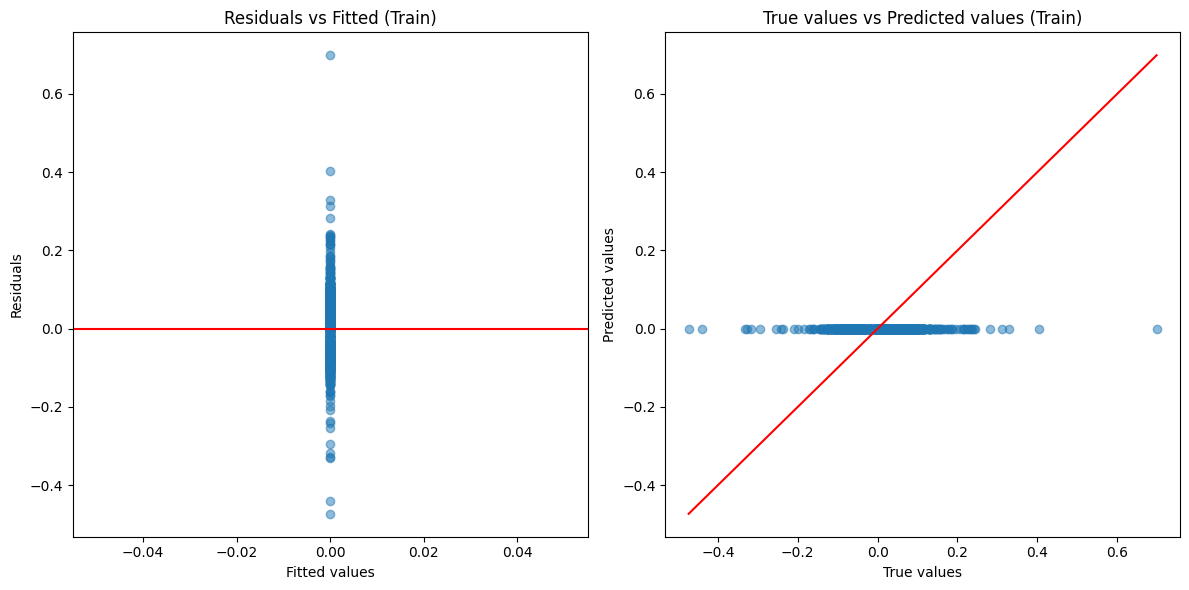

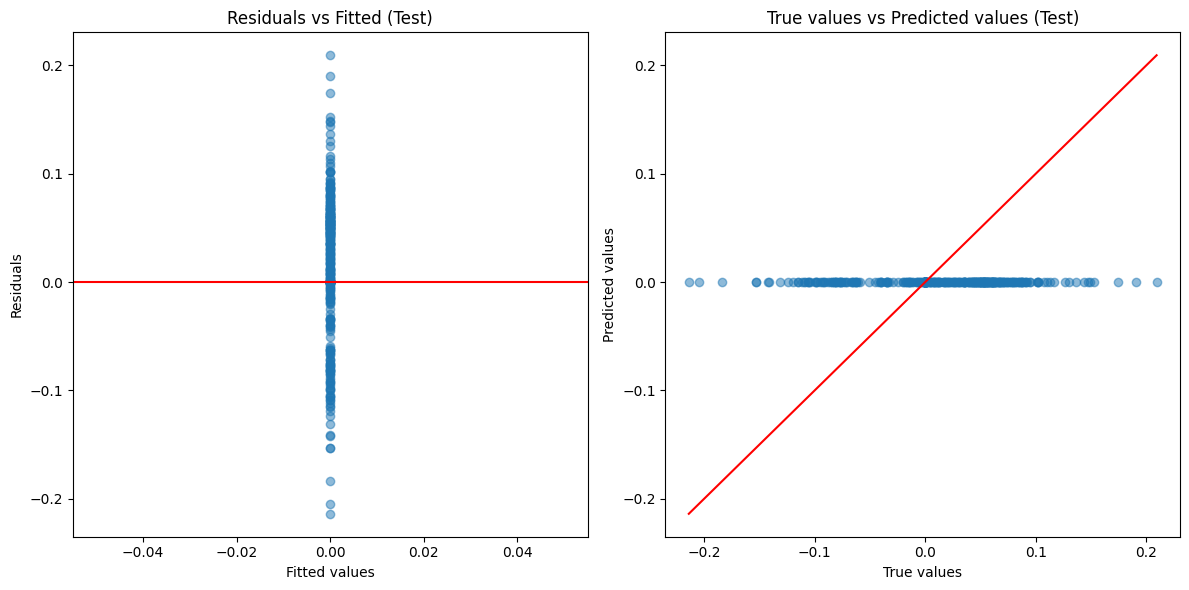

In [20]:
bm = baseline_model().fit(X_train, y_train)
e.evaluate(bm, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


Evaluation for RandomForestRegressor(verbose=1) (Train)
Max Error: 0.2205789612000003
Mean Absolute Error: 0.011693521960766206
Mean Squared Error: 0.00048646707173357945
Root Mean Squared Error: 0.022055998543107937
R-Squared: 0.8761845174035299
----------------------------
Evaluation for RandomForestRegressor(verbose=1) (Test)
Max Error: 0.25534253292049
Mean Absolute Error: 0.026224999558947252
Mean Squared Error: 0.0018887489751995266
Root Mean Squared Error: 0.04345973970469136
R-Squared: 0.1306218436389781
----------------------------
Feature Importances for RandomForestRegressor(verbose=1)
posteam_rush_epa_per_sec: 0.15315264134776518
wp_avg: 0.12508633714507073
posteam_pass_epa_per_sec: 0.11704553725152878
drive_play_count: 0.1037449305955667
game_seconds_remaining: 0.10372858212316359
drive: 0.05124883537305635
score_differential: 0.0437651057096614
wp_difference: 0.04252053780874048
ep: 0.03228965850420917
fg_prob: 0.030523518277715867
half_seconds_remaining: 0.02918190381049

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


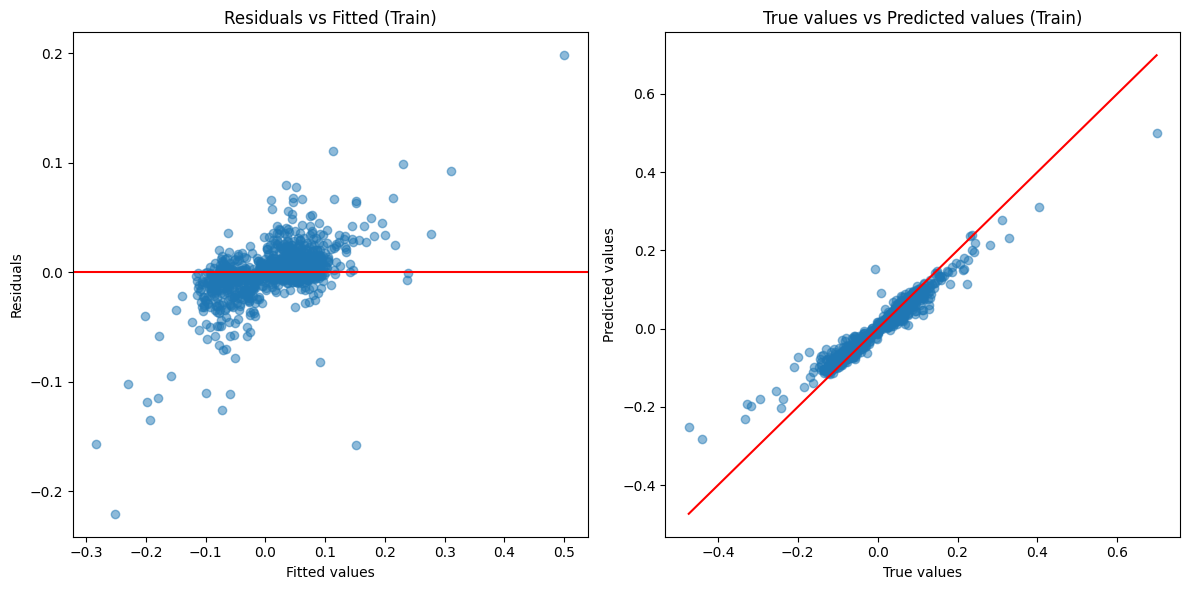

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


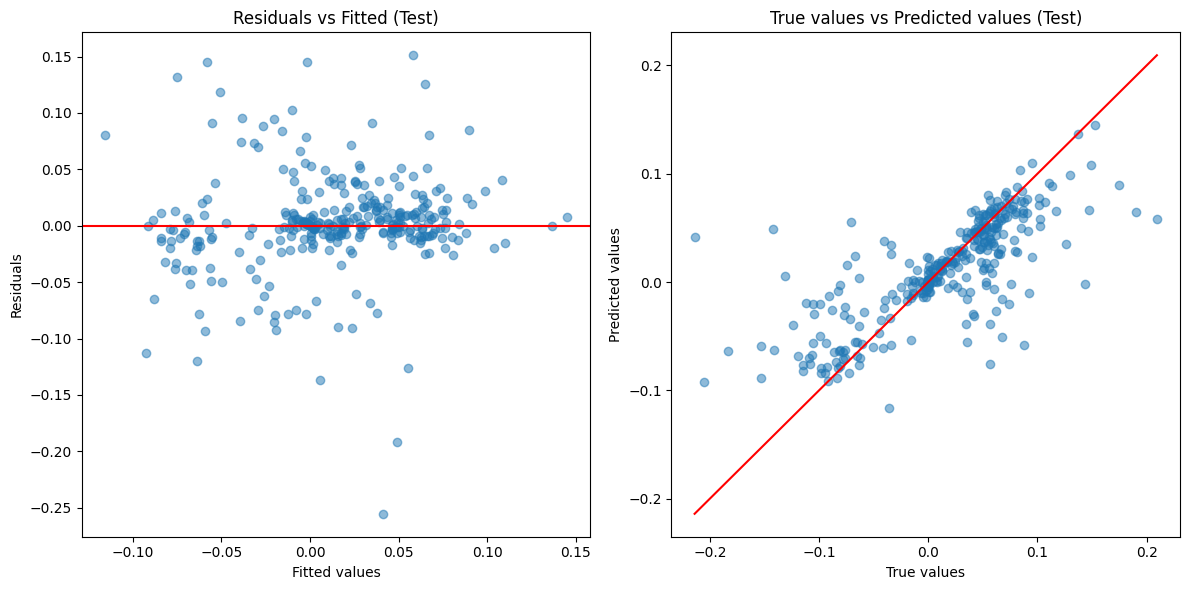

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(verbose=1)
rf.fit(X_train, y_train)
e.evaluate(rf,X_train, X_test, y_train, y_test, )

In [23]:
rf = RandomForestRegressor()

# Define a parameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [60],
    'min_samples_split': [2],
    'max_features':  [0.7, 0.8,0.9]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train) 

best_params = grid_search.best_params_
print(best_params)

best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'max_depth': 60, 'max_features': 0.7, 'min_samples_split': 2, 'n_estimators': 100}


Evaluation for RandomForestRegressor(max_depth=60, max_features=0.7) (Train)
Max Error: 0.2283972415919997
Mean Absolute Error: 0.011780217168919334
Mean Squared Error: 0.0004827749633253297
Root Mean Squared Error: 0.021972140617730666
R-Squared: 0.8735178785909612
----------------------------
Evaluation for RandomForestRegressor(max_depth=60, max_features=0.7) (Test)
Max Error: 0.2349642778
Mean Absolute Error: 0.02629322557055478
Mean Squared Error: 0.001825096496360321
Root Mean Squared Error: 0.04272114811613004
R-Squared: 0.07489246000497107
----------------------------
Feature Importances for RandomForestRegressor(max_depth=60, max_features=0.7)
posteam_rush_epa_per_sec: 0.14777506875631738
drive_play_count: 0.11051274428911492
wp_avg: 0.11051258887409202
game_seconds_remaining: 0.10596655018144997
posteam_pass_epa_per_sec: 0.09687023558168681
score_differential: 0.05251616209163438
drive: 0.04740593852378566
wp_difference: 0.04537284380990651
ep: 0.036044592455264715
ydsnet: 0.

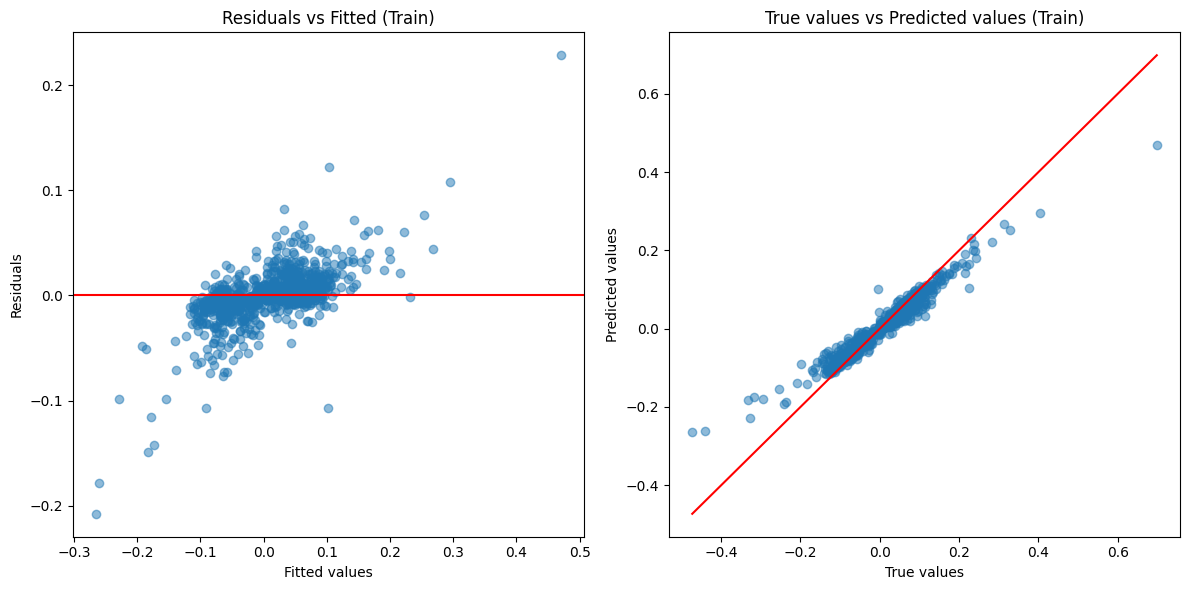

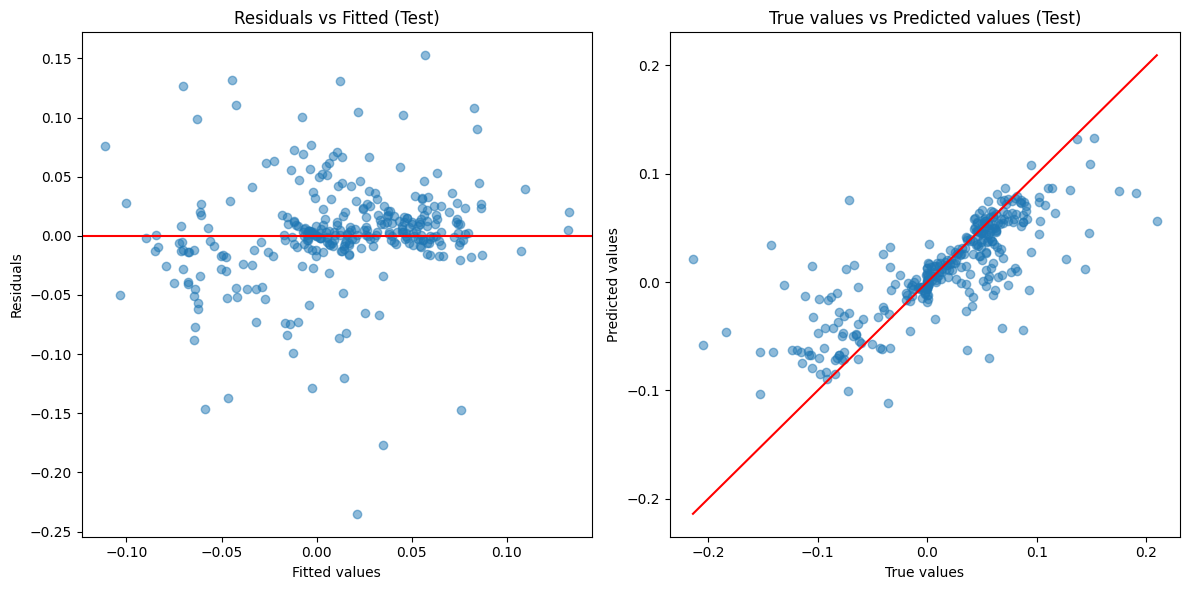

In [24]:
e.evaluate(best_rf_model, X_train, X_test, y_train, y_test)

In [ ]:
params = {
    'posteam_rush_epa_per_sec': 0.15361521161023423,
    'wp_avg': 0.11255346080118929,
    'drive_play_count': 0.10510862419073477,
    'posteam_pass_epa_per_sec': 0.10247794254126485,
    'wpa_difference': 0.09861196437043832,
    'game_seconds_remaining': 0.09463776321693064,
    'drive': 0.05296342985086211,
    'score_differential': 0.0339826815766261,
    'fg_prob': 0.030565795301382682,
    'wp_difference': 0.029548685517214693,
    'ep': 0.02570305271665878,
    'ydsnet': 0.021628274702826574,
    'yardline_100': 0.019947539254548893,
    'half_seconds_remaining': 0.019108004508091227,
    'td_prob': 0.018153540377083756,
    'no_score_prob': 0.01632547342416568,
    'posteam_spread_line': 0.015199464839700248,
    'spread_line': 0.013699004241930214,
    'week': 0.012309058957629302,
    'defteam_timeouts_remaining': 0.00640673645289036,
    'year': 0.005820983392395352,
    'ydstogo': 0.004877902917708732,
    'posteam_timeouts_remaining': 0.0034256100970587377,
    'posteam_is_home': 0.0019129129026322575,
    'no_huddle': 0.0008135179992865084,
    'is_reg_season': 0.0006033642385157559
}
feature_remove_order = list(params.keys())
feature_remove_order.reverse()

In [ ]:
y = run['wpa_avg'].to_numpy()
X = run.drop('wpa_avg', axis=1)
cols = X.columns

e = regression_evaluator(cols)
num_features = []
scores = []

for feature in feature_remove_order:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    nf = X_train.shape[1]
    num_features.append(nf)
    
    best_rf_model.fit(X_train, y_train)
    
    
    e.metrics(best_rf_model, X_train, y_train, message="Train",return_type="R-Squared")
    r2_test = e.metrics(best_rf_model, X_test, y_test, message="Test",return_type="R-Squared")
    scores.append(r2_test)
    print("\n----------------------------\n")
    print(f"Removing {feature}")
    X = X.drop(feature, axis=1)
    
plt.plot(num_features, scores)

In [ ]:
plt.plot(num_features, scores)

In [ ]:
'''
1.
{'max_depth': 50, 'max_features': 0.8, 'min_samples_split': 2, 'n_estimators': 40}
Evaluation for RandomForestRegressor(max_depth=50, max_features=0.8, n_estimators=40) (Train)
Max Error: 0.2412799337
Mean Absolute Error: 0.012557483698143367
Mean Squared Error: 0.0005457895090584143
Root Mean Squared Error: 0.02336213836656256
R-Squared: 0.8602916889169081
----------------------------
Evaluation for RandomForestRegressor(max_depth=50, max_features=0.8, n_estimators=40) (Test)
Max Error: 0.19398084710000002
Mean Absolute Error: 0.027010970760887862
Mean Squared Error: 0.001815803885412712
Root Mean Squared Error: 0.04261225041478931
R-Squared: 0.21716164465394328
----------------------------
Feature Importances for RandomForestRegressor(max_depth=50, max_features=0.8, n_estimators=40)
wp_avg: 0.2024287266345271
game_seconds_remaining: 0.18768938919192563
posteam_rush_epa_per_sec: 0.18073361316670655
posteam_pass_epa_per_sec: 0.15045991532860234
wpa_difference: 0.14990200083642788
drive_play_count: 0.12878635484181045


2.
{'max_depth': 55, 'max_features': 0.6, 'min_samples_split': 2, 'n_estimators': 40}
Evaluation for RandomForestRegressor(max_depth=55, max_features=0.6, n_estimators=40) (Train)
Max Error: 0.27670066234999996
Mean Absolute Error: 0.012354027332684831
Mean Squared Error: 0.0005414596883825575
Root Mean Squared Error: 0.02326928637458737
R-Squared: 0.8590339740872817
----------------------------
Evaluation for RandomForestRegressor(max_depth=55, max_features=0.6, n_estimators=40) (Test)
Max Error: 0.21380634195
Mean Absolute Error: 0.028025313749364164
Mean Squared Error: 0.001968765098644003
Root Mean Squared Error: 0.04437076851536384
R-Squared: 0.021389395446389736
----------------------------
Feature Importances for RandomForestRegressor(max_depth=55, max_features=0.6, n_estimators=40)
wp_avg: 0.20179725846107105
posteam_rush_epa_per_sec: 0.1821661618147025
game_seconds_remaining: 0.17461769604115895
wpa_difference: 0.15697113249657663
posteam_pass_epa_per_sec: 0.15294278639318906
drive_play_count: 0.13150496479330184
----------------------------

3. 
{'max_depth': 55, 'max_features': 0.8, 'min_samples_split': 2, 'n_estimators': 40}
'''

In [ ]:
def partition(data, play_type="pass"):
    return data[data['play_type'] == play_type].drop('play_type', axis=1)